In [67]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score,precision_score, recall_score, accuracy_score, confusion_matrix

In [80]:
df=pd.read_csv("data/ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [69]:
# 1. Data Loading & Engineering
df = pd.read_csv('ai4i2020.csv')
data = df.drop(['UDI', 'Product ID'], axis=1)

le = LabelEncoder()
data['Type'] = le.fit_transform(data['Type'])
# Custom features for mechanical insight
data['Temp_Diff'] = data['Process temperature [K]'] - data['Air temperature [K]']
data['Power_Factor'] = data['Torque [Nm]'] * data['Rotational speed [rpm]']

X = data.drop(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
y = data['Machine failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [70]:
# 2. Scaling (For SVM/Logistic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
# 3. Which model is best for Fault Detection
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'SVM': SVC(class_weight='balanced', probability=True),
    'GBM (Enhanced)': GradientBoostingClassifier(n_estimators=150)
}

results = []
for name, model in models.items():
    X_train_run = X_train_scaled if name in ['Logistic Regression', 'SVM'] else X_train
    X_test_run = X_test_scaled if name in ['Logistic Regression', 'SVM'] else X_test
    
    model.fit(X_train_run, y_train)
    y_pred = model.predict(X_test_run)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })
print(results)

[{'Model': 'Logistic Regression', 'Accuracy': 0.86, 'Precision': 0.18072289156626506, 'Recall': 0.8823529411764706, 'F1-Score': 0.3}, {'Model': 'Decision Tree', 'Accuracy': 0.982, 'Precision': 0.7580645161290323, 'Recall': 0.6911764705882353, 'F1-Score': 0.7230769230769231}, {'Model': 'Random Forest', 'Accuracy': 0.9885, 'Precision': 0.9591836734693877, 'Recall': 0.6911764705882353, 'F1-Score': 0.8034188034188035}, {'Model': 'SVM', 'Accuracy': 0.9205, 'Precision': 0.2843601895734597, 'Recall': 0.8823529411764706, 'F1-Score': 0.43010752688172044}, {'Model': 'GBM (Enhanced)', 'Accuracy': 0.991, 'Precision': 0.9310344827586207, 'Recall': 0.7941176470588235, 'F1-Score': 0.8571428571428571}]


C:\Users\hp\AppData\Local\Temp\ipykernel_11152\853732486.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-Score', y='Model', data=results_df, palette='magma')


Text(0.5, 1.0, 'Performance Comparison: F1-Score')

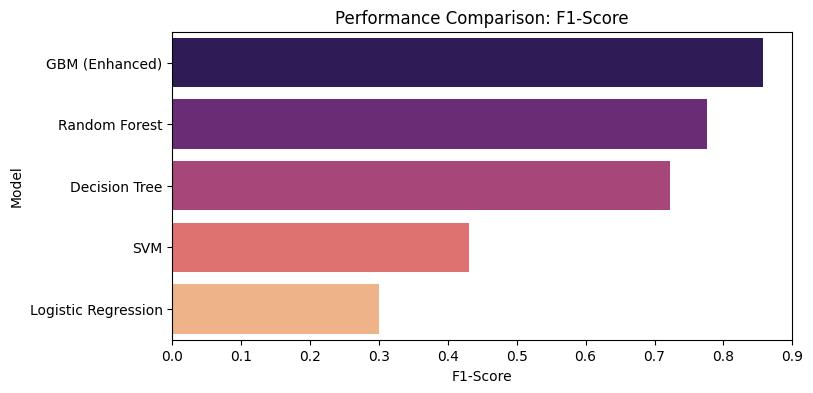

In [79]:
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)
# print("\n--- Model Comparison Table ---")
# print(results_df)

plt.figure(figsize=(8, 4))
sns.barplot(x='F1-Score', y='Model', data=results_df, palette='magma')
plt.title('Performance Comparison: F1-Score')

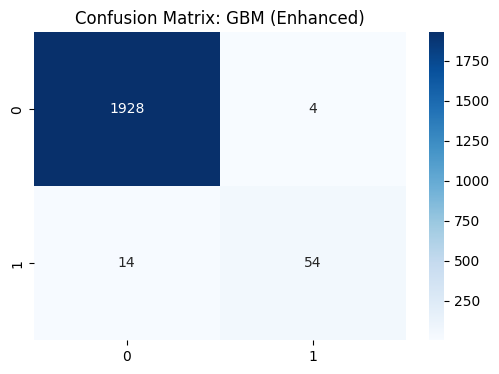

In [73]:
# Detailed Matrix for the Winner
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
# Test the best model
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.savefig('winner_confusion_matrix.png')

In [75]:
final_model = best_model
final_model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,150
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [76]:
# Save for deployment
joblib.dump(final_model, 'assets/champion_model.pkl')
joblib.dump(le, 'assests/label_encoder.pkl')
print("Champion model exported successfully!")

Champion model exported successfully!
